In [18]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=ChatGroq(model="qwen-2.5-32b")

In [19]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class State(TypedDict):
    input_code:str
    review: str
    generate_testcases:str
    run_tests:str
    analyze_fail_test:str
    summary: str
    


In [26]:
def review(state: State):
    print(state)
    data = llm.invoke(f"Please take this snippet code {state['input_code']} and review of the code and give the after reviewed code")
    return {"review": data.content}

def generate_testcases(state: State):
    data = llm.invoke(f"Please generate the testcases based on the  {state["review"]}")
    return {"generate_testcases": data.content}

def run_tests(state: State):
    data = llm.invoke(f"Please run the testcases for this code {state["generate_testcases"]}")
    return {"run_tests": data.content}

def analyze_fail_test(state: State):
    data = llm.invoke(f"Please analyze the failed testcases for this code {state["run_tests"]}")
    return {"analyze_fail_test": data.content}

def summary(state: State):
    data = llm.invoke(f"Please summaryize the {state["analyze_fail_test"]}")
    return {"summary": data.content}

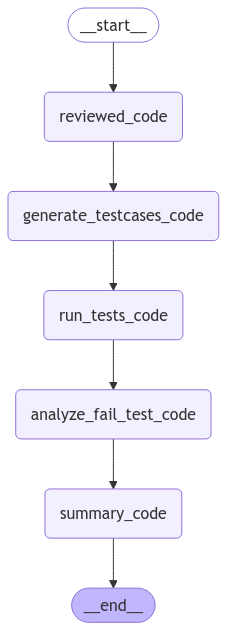

In [27]:

workflow = StateGraph(State)
workflow.add_node("reviewed_code", review)
workflow.add_node("generate_testcases_code", generate_testcases)
workflow.add_node("run_tests_code", run_tests)
workflow.add_node("analyze_fail_test_code", analyze_fail_test)
workflow.add_node("summary_code", summary)


# Add edges to connect nodes
workflow.add_edge(START, "reviewed_code")
workflow.add_edge("reviewed_code", "generate_testcases_code")
workflow.add_edge("generate_testcases_code", "run_tests_code")
workflow.add_edge("run_tests_code", "analyze_fail_test_code")
workflow.add_edge("analyze_fail_test_code", "summary_code")
workflow.add_edge("summary_code", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [28]:
state = chain.invoke({"input_code": """@app.get('/')
def home():
    return {"Message": 'Hello World'}"""})

{'input_code': '@app.get(\'/\')\ndef home():\n    return {"Message": \'Hello World\'}'}


In [33]:
state
state['summary']

'Certainly! To summarize the process of analyzing failed test cases, here are the key steps:\n\n1. **Identify the Error Message**: Start by closely reading the error message to understand the nature of the failure.\n\n2. **Review the Test Case**: Examine the specific test case that failed. This involves understanding the input provided to the function, the expected output, and the actual output produced.\n\n3. **Compare Outputs**: If the test case involves an assertion error, compare the expected output to the actual output to identify discrepancies.\n\n4. **Inspect the Code**: Look at the section of the code that is being tested. Based on the test failure and the error message, hypothesize what might be going wrong. This could involve checking for logical errors, incorrect implementation, or issues with edge cases.\n\n5. **Debugging**: Utilize debugging tools or add print statements in the code to track the flow and variable values, helping to pinpoint the exact cause of the failure.\